# GAN: learn to generate any kind of vegetables or fruits (instead of numbers-pictures of vegetables or fruits) -- for example apples:

In [0]:
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import sys
import os
import time

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

from google.colab import drive


drive.mount('/content/gdrive')

IMG_PATH = '/content/gdrive/My Drive/DLSchool/Downloaded/GAN/banana'#shiitake'
SAVE_PATH = '/content/gdrive/My Drive/DLSchool/Completed/gan/banana'#shiitake'
img_list = os.listdir(IMG_PATH)
print(len(img_list))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
1068


Data for training are taken from ImageNet.
To do this I saved the links to the pictures in a text file and downloaded it locally using the following script:

In [0]:
import urllib
import os


save_path = 'd:\\Dima\\DLSchool\\ImageNet_download\\banana'
with open('d:\\Dima\\DLSchool\\ImageNet_download\\banana_urls.txt', 'r') as f:
    lines = f.readlines()
    cnt = 0
    for line in lines:
        name = line.strip().split('/')[-1]
        try:
            urllib.request.urlretrieve(line, os.path.join(save_path, name))
            cnt += 1
        except Exception as e:
            print(e)
            print(cnt)
    print('total:', cnt)

It turned out a little more than 1000 pictures.
Let's see what size they are and determine the minimum.

It turns out 100 pixels.
To this magnitude planned lead all pictures of the under shaping patch, however then took, as in example from the Internet (hence: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py )
size 28 and DCGAN.

In [0]:
sz_set = set()
bad_im = []
for im in tqdm_notebook(img_list):
    try:
        img = Image.open(IMG_PATH + '/' + im)
        if img.size not in sz_set:
            sz_set.add(img.size)
    except Exception as e:
        print(e)
        bad_im.append(im)
print(sz_set)
print(bad_im)
img_list = [im for im in img_list if im not in bad_im]
print(len(img_list))
sz_set = np.array(list(sz_set))
print(sz_set.shape)
IMG_SIZE = np.min(sz_set)
print(IMG_SIZE)

cannot identify image file '/content/gdrive/My Drive/DLSchool/Downloaded/GAN/banana/fruit.jpg'
cannot identify image file '/content/gdrive/My Drive/DLSchool/Downloaded/GAN/banana/banana.jpg'
cannot identify image file '/content/gdrive/My Drive/DLSchool/Downloaded/GAN/banana/banana_arp_750pix.jpg'

{(500, 343), (256, 192), (425, 283), (500, 438), (376, 499), (320, 212), (499, 166), (500, 322), (500, 268), (500, 500), (499, 356), (332, 499), (500, 381), (380, 500), (500, 360), (500, 402), (420, 308), (480, 360), (356, 500), (499, 242), (499, 412), (384, 500), (500, 159), (500, 340), (500, 427), (395, 480), (500, 327), (500, 316), (500, 489), (426, 500), (499, 355), (500, 422), (383, 500), (334, 500), (500, 370), (300, 400), (500, 251), (500, 365), (499, 338), (499, 327), (477, 500), (132, 100), (500, 350), (499, 376), (500, 329), (499, 396), (345, 500), (450, 418), (333, 500), (500, 324), (499, 299), (375, 499), (500, 375), (500, 300), (379, 500), (500, 409), (250, 500), (500, 354), (340

Creating a function that will read from the list of files a random set of a given value and convert them to the desired format

(4, 28, 28, 3)


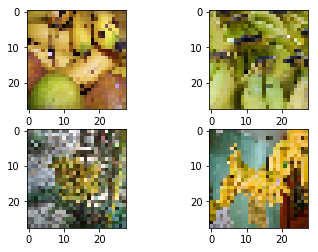

In [0]:
IMG_SIZE = 28

def batch_generator(img_list, batch_size):
    batch_list = np.random.choice(img_list, batch_size)
    img_batch = np.empty((batch_size, IMG_SIZE, IMG_SIZE, 3))

    for i, im in enumerate(batch_list):
        img = Image.open(IMG_PATH + '/' + im)
        img = img.convert('RGB')
        img = np.array(img.resize((IMG_SIZE, IMG_SIZE)), dtype='float32')
        img_batch[i, :] = img

    img_batch = np.array(img_batch) / 255.
    return img_batch

batch = batch_generator(img_list, 4)
print(batch.shape)

plt.subplot(2, 2, 1)
plt.imshow(batch[0])
plt.subplot(2, 2, 2)
plt.imshow(batch[1])
plt.subplot(2, 2, 3)
plt.imshow(batch[2])
plt.subplot(2, 2, 4)
plt.imshow(batch[3])
plt.show()

Deep Concolutional GAN

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = IMG_SIZE
        self.img_cols = IMG_SIZE
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

#         model.add(Dense(256, input_dim=self.latent_dim))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(512))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(1024))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Dense(np.prod(self.img_shape), activation='tanh'))
#         model.add(Reshape(self.img_shape))

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))        
        
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

#         model.add(Flatten(input_shape=self.img_shape))
#         model.add(Dense(512))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dense(256))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dense(1, activation='sigmoid'))
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))        
        
        
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, img_list, epochs=100, batch_size=16, sample_interval=100):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            imgs = batch_generator(img_list, batch_size)
            # Rescale -1 to 1
            imgs = 2 * imgs - 1

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        #gen_imgs = gen_imgs.reshape((-1, 28, 3))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        #gen_imgs = np.asarray(gen_imgs, dtype=np.uint8);
        #imgs = Image.fromarray(gen_imgs);

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])#, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(SAVE_PATH + '/' + str(epoch) + '.png')
        plt.close()

In [0]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

In [0]:
%%time
gan.train(img_list, epochs=50000, batch_size=128)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.406716, acc.: 31.64%] [G loss: 0.427711]
100 [D loss: 0.613875, acc.: 67.97%] [G loss: 0.629528]
200 [D loss: 0.848122, acc.: 45.70%] [G loss: 1.094632]
300 [D loss: 0.715232, acc.: 57.42%] [G loss: 0.762777]
400 [D loss: 0.694779, acc.: 58.59%] [G loss: 0.739896]
500 [D loss: 0.738129, acc.: 54.30%] [G loss: 0.828417]
600 [D loss: 0.774178, acc.: 44.53%] [G loss: 0.777047]
700 [D loss: 0.674816, acc.: 58.20%] [G loss: 0.857706]
800 [D loss: 0.606173, acc.: 71.09%] [G loss: 0.668576]
900 [D loss: 0.650313, acc.: 64.45%] [G loss: 0.707861]
1000 [D loss: 0.678417, acc.: 58.59%] [G loss: 0.776212]
1100 [D loss: 0.736987, acc.: 53.12%] [G loss: 0.785909]
1200 [D loss: 0.756179, acc.: 47.66%] [G loss: 0.797181]
1300 [D loss: 0.641313, acc.: 66.41%] [G loss: 0.792968]
1400 [D loss: 0.450615, acc.: 82.42%] [G loss: 0.546555]
1500 [D loss: 0.641736, acc.: 65.23%] [G loss: 0.962918]
1600 [D loss: 0.868109, acc.: 38.28%] [G loss: 0.675709]
1700 [D loss: 0.659317, acc.: 60.55%] [G lo

KeyboardInterrupt: ignored

Unfortunately, DCGAN's training proved to be too long and there is no way to continue.
Let's estimate the intermediate result by 30,000 epochs (out of the given 50,000).
To do this, output an array of original images 5x5 - in the form in which they are stored in the learning process for control.
Size-28x28

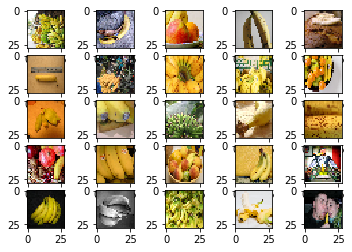

In [0]:
batch = batch_generator(img_list, 25)
batch = iter(batch)

fig, ax = plt.subplots(nrows=5, ncols=5)
for r in range(5):
    for c in range(5):
        ax[r, c].imshow(next(batch))
plt.show()

And now we will display a picture from the era of 300.
On it, the accuracy was 91.41% - which means that only 117 images out of 128 (in Butch) were recognized correctly, and 11 incorrectly.

It can be seen that the result of the generation has a distant similarity and gradually approaches the real pictures.

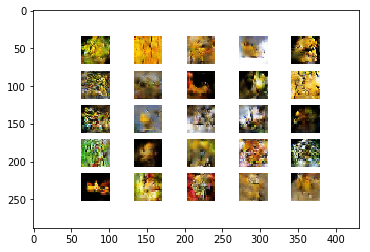

In [0]:
img = Image.open(SAVE_PATH + '/30300.png')
img = img.convert('RGB')
plt.imshow(img)

In [81]:
128*0.9141

117.0048